In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import re

In [2]:
df = pd.read_csv('../data/1_predicted_category_documents.csv')

if "PY" not in df.columns:
    import django, sys, os
    sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
    os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
    django.setup()

    from scoping.models import *

    pydf = df.sort_values('id')
    pys = Doc.objects.filter(id__in=pydf['id']).order_by('PY').values_list('PY',flat=True)
    pydf['PY'] = pys
    df = pydf.sort_index()
    
    df.to_csv('../data/1_predicted_category_documents.csv', index=False)

print(df.shape)
df = df.merge(pd.read_csv('../data/1_document_relevance.csv'))
df.head()

(120265, 228)


,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,random_sample,...,2 - 2.4. Sensitivity - upper_pred,2 - 2.5. Detection of a regional climate trend (no attribution) - mean_prediction,2 - 2.5. Detection of a regional climate trend (no attribution) - std_prediction,2 - 2.5. Detection of a regional climate trend (no attribution) - lower_pred,2 - 2.5. Detection of a regional climate trend (no attribution) - upper_pred,PY,0 - relevance - mean_prediction,0 - relevance - std_prediction,0 - relevance - lower_pred,0 - relevance - upper_pred
0,0,701728,The cryosphere of mountain regions is highly s...,Mapping the snow line altitude for large glaci...,NaN,NaN,NaN,0.0,0.0,0,...,0.154874,0.180441,0.057526,0.122916,0.237967,2011.0,0.529285,0.046927,0.482358,0.576212
1,1,213918,Global warming has been predicted to slow the ...,Can in situ floats and satellite altimeters de...,NaN,"['Geosciences, Multidisciplinary']",NaN,0.0,0.0,0,...,0.181101,0.144460,0.037500,0.106960,0.181960,2002.0,0.586445,0.062096,0.524349,0.648541
2,2,384698,Droughts and landfalling tropical cyclones (TC...,Spatiotemporal patterns of drought/tropical cy...,NaN,NaN,NaN,0.0,0.0,0,...,0.409908,0.065376,0.009665,0.055711,0.075041,2006.0,0.732945,0.042883,0.690062,0.775827
3,3,275009,High latitude ecosystems are believed to be se...,Changes in nitrogen content and isotopic compo...,NaN,['Environmental Sciences'],NaN,0.0,0.0,0,...,0.435428,0.092876,0.023834,0.069042,0.116709,2004.0,0.643515,0.037923,0.605592,0.681439
4,4,36030,Landscape-scale net ecosystem CO2 exchange (NE...,Interannual variability of net ecosystem CO2 e...,NaN,"['Environmental Sciences; Geosciences, Multidi...",NaN,0.0,0.0,0,...,0.640520,0.049790,0.009166,0.040624,0.058956,1992.0,0.756610,0.045044,0.711566,0.801654


In [3]:
[x for x in df.columns if "relev" in x]

['relevant',
 '0 - relevance - mean_prediction',
 '0 - relevance - std_prediction',
 '0 - relevance - lower_pred',
 '0 - relevance - upper_pred']

Text(0, 0.5, 'Number of documents')

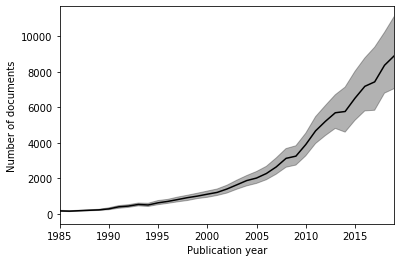

In [4]:
fig, ax = plt.subplots()

pcols = [
    '0 - relevance - mean_prediction',
    '0 - relevance - lower_pred',
    '0 - relevance - upper_pred'
]

df.loc[df['relevant']==1,pcols]=1

lb = df[df['0 - relevance - lower_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"lb"})
mid = df[df['0 - relevance - mean_prediction']>0.5].groupby('PY')['id'].size().to_frame().reset_index()
ub = df[df['0 - relevance - upper_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"ub"})

bounds = lb.merge(ub, how="outer")

ax.plot(mid['PY'], mid['id'], color="black")

ax.fill_between(
    bounds['PY'], bounds['lb'], bounds['ub'],
    color="black",
    alpha=0.3
)

ax.set_xlim([1985,2019])

ax.set_xlabel('Publication year')
ax.set_ylabel('Number of documents')

(1985.0, 2022.0)

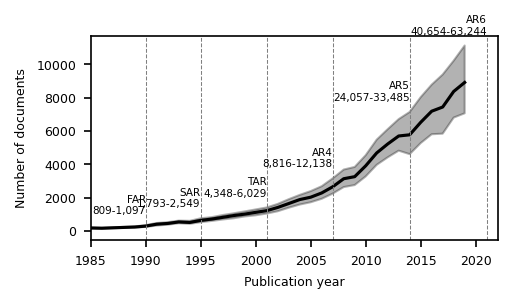

In [5]:
fig, ax = plt.subplots(dpi=150, figsize=(3.5,1.8))

lb = df[df['0 - relevance - lower_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"lb"})
mid = df[df['0 - relevance - mean_prediction']>0.5].groupby('PY')['id'].size().to_frame().reset_index()
ub = df[df['0 - relevance - upper_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"ub"})

mid = mid[mid['PY']<2020]

bounds = lb.merge(ub, how="outer")

bounds = bounds[bounds['PY']<2020]

ax.plot(mid['PY'], mid['id'], color="black")

ax.fill_between(
    bounds['PY'], bounds['lb'], bounds['ub'],
    color="black",
    alpha=0.3
)

ax.set_xlim([1985,2019])

ax.set_xlabel('Publication year', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)

ax.tick_params(axis='both', labelsize=6) 

report_dates = [1990, 1995, 2001, 2007, 2014, 2021]
report_labels = ["FAR", "SAR", "TAR", "AR4", "AR5", "AR6"]

ymax = ub['ub'].max()

ld = 0

for d, l in zip(report_dates, report_labels):
    #idx = py_range.index(d)
    
    # bounds for this reporting period
    r_lb = lb[lb['PY'].isin(range(ld,d))]['lb'].sum()
    r_ub = ub[ub['PY'].isin(range(ld,d))]['ub'].sum()
    

    
    if l=="AR6":
        y = ub[ub['PY']==d-2].ub.values[0]
        ty = y+ymax*0.05 + (1-y/ymax)*0.1
        ax.axvline(d, color="grey",lw=0.5, ls="--")
        ax.text(d, ty, f"{l}\n{r_lb:,}-{r_ub:,}", va="bottom", ha="right", fontsize=5)
    else:
        y = ub[ub['PY']==d].ub.values[0]
        ty = y+ymax*0.05 + (1-y/ymax)*0.1
        ax.axvline(d, color="grey",lw=0.5, ls="--")
        ax.text(d, ty, f"{l}\n{r_lb:,}-{r_ub:,}", va="bottom", ha="right", fontsize=5)

    ld=d

ax.set_xlim([1985,2022])
#ax.plot(lb['PY'],lb['id'])
#ax.plot(ub['PY'],ub['id'])

Text(0, 0.5, 'Number of documents')

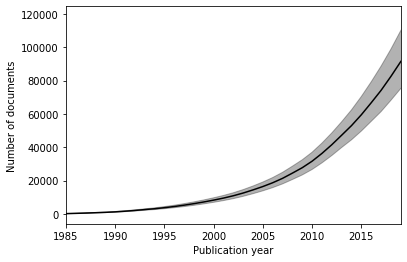

In [6]:
fig, ax = plt.subplots()

lb = df[df['0 - relevance - lower_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"lb"})
mid = df[df['0 - relevance - mean_prediction']>0.5].groupby('PY')['id'].size().to_frame().reset_index()
ub = df[df['0 - relevance - upper_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"ub"})

bounds = lb.merge(ub, how="outer")

ax.plot(mid['PY'], mid['id'].cumsum(), color="black")

ax.fill_between(
    bounds['PY'], bounds['lb'].cumsum(), bounds['ub'].cumsum(),
    color="black",
    alpha=0.3
)

ax.set_xlim([1985,2019])

ax.set_xlabel('Publication year')
ax.set_ylabel('Number of documents')



#ax.plot(lb['PY'],lb['id'])
#ax.plot(ub['PY'],ub['id'])

In [7]:
lb = df[df['0 - relevance - lower_pred']>0.5].shape[0]
mid = df[df['0 - relevance - mean_prediction']>0.5].shape[0]
ub = df[df['0 - relevance - upper_pred']>0.5].shape[0]

print(lb, mid, ub)

80968 98802 119292


In [8]:
pred_cats = [c for c  in df.columns if "12 - " in c and " - mean_prediction" in c]
for c in pred_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    cs = [c, c.replace('mean_prediction','lower_pred'), c.replace('mean_prediction','upper_pred')]
    df.loc[df[label]==1,cs] = 1
    print(df[c].sum())
print(pred_cats)

pred_cats = [
    "12 - Terrestrial ES - mean_prediction",
    "12 - Coastal and marine Ecosystems - mean_prediction",
    "12 - Mountains, snow and ice - mean_prediction",
    "12 - Rivers, lakes, and soil moisture - mean_prediction",
    "12 - Human and managed - mean_prediction"
    
]

16663.56853902418
16799.56853902418
20151.340275980354
20414.340275980354
6370.38864770765
6505.399679651162
18346.567023831227
18614.56702383123
42423.04180061863
42839.04180061863
['12 - Coastal and marine Ecosystems - mean_prediction', '12 - Human and managed - mean_prediction', '12 - Mountains, snow and ice - mean_prediction', '12 - Rivers, lakes, and soil moisture - mean_prediction', '12 - Terrestrial ES - mean_prediction']


[Text(0, 0, 'Terrestrial ES'),
 Text(0, 0, 'Coastal and marine ES'),
 Text(0, 0, 'Mountains, snow and ice'),
 Text(0, 0, 'Rivers, lakes\n and soil moisture'),
 Text(0, 0, 'Human and managed')]

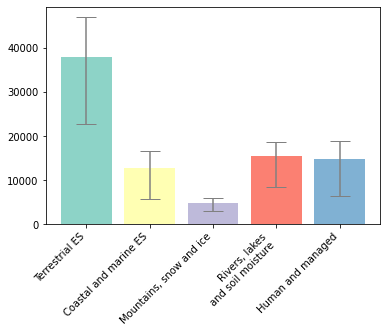

In [9]:
fig, ax = plt.subplots()
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3']

xticks = []
for i, c in enumerate(pred_cats):
    mid = df[
        (df['0 - relevance - mean_prediction']>0.5) & 
        (df[c]>0.5)
    ].shape[0]
    ub = df[
        (df['0 - relevance - upper_pred']>0.5) & 
        (df[c.replace('mean_prediction','upper_pred')]>0.5)
    ].shape[0]
    lb = df[
        (df['0 - relevance - lower_pred']>0.5) & 
        (df[c.replace('mean_prediction','lower_pred')]>0.5)
    ].shape[0]
    ax.bar(i, mid,color=colors[i])
    
    eay = np.array([[ub-mid,mid-lb]]).T
    
    ax.errorbar(i, mid, yerr=eay, color="grey", capsize=10)
    
    xticks.append(c.split("-")[1].strip())
    
ax.set_xticks(range(i+1))

xticks = [
    "Terrestrial ES",
    "Coastal and marine ES",
    "Mountains, snow and ice",
    "Rivers, lakes\n and soil moisture",
    "Human and managed",    
]
ax.set_xticklabels(xticks, rotation=45,ha="right")
    

In [22]:
attrib_cats = [c for c  in df.columns if "2 - " in c and " - mean_prediction" in c and not "12 - " in c]
for c in attrib_cats:
    print(df[df[c]>0.5].shape[0])
    label = c.replace(" - mean_prediction",'')
    cs = [c, c.replace('mean_prediction','lower_pred'), c.replace('mean_prediction','upper_pred')]
    df.loc[df[label]==1,cs] = 1
    #df.loc[df[label]==1,c] = 1
    print(df[df[c]>0.5].shape[0])
attrib_cats

43465
43465
31020
31020
1312
1312


['2 - Trend or climate change attribution - mean_prediction',
 '2 - 2.4. Sensitivity - mean_prediction',
 '2 - 2.5. Detection of a regional climate trend (no attribution) - mean_prediction']

[Text(0, 0, 'Trend attribution'),
 Text(0, 0, 'Sensitivity'),
 Text(0, 0, 'Detection')]

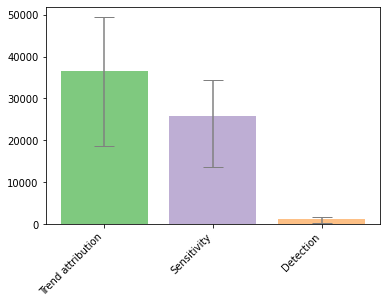

In [11]:
fig, ax = plt.subplots()
colors = ['#7fc97f','#beaed4','#fdc086']

xticks = []
for i, c in enumerate(attrib_cats):
    mid = df[
        (df['0 - relevance - mean_prediction']>0.5) & 
        (df[c]>0.5)
    ].shape[0]
    ub = df[
        (df['0 - relevance - upper_pred']>0.5) & 
        (df[c.replace('mean_prediction','upper_pred')]>0.5)
    ].shape[0]
    lb = df[
        (df['0 - relevance - lower_pred']>0.5) & 
        (df[c.replace('mean_prediction','lower_pred')]>0.5)
    ].shape[0]
    ax.bar(i, mid,color=colors[i])
    
    eay = np.array([[ub-mid,mid-lb]]).T
    
    ax.errorbar(i, mid, yerr=eay, color="grey", capsize=10)
    
    xticks.append(c.split("-")[1].strip())
    
ax.set_xticks(range(i+1))

xticks = [
    "Trend attribution",
    "Sensitivity",
    "Detection"
]
ax.set_xticklabels(xticks, rotation=45,ha="right")
    

In [12]:
doc_continents = pd.read_csv('../data/doc_continents.csv').merge(pd.read_csv('../data/1_document_relevance.csv'), left_on="doc_id",right_on="id")
doc_continents.head()

,doc_id,continent,id,0 - relevance - mean_prediction,0 - relevance - std_prediction,0 - relevance - lower_pred,0 - relevance - upper_pred
0,1340101,NaN,1340101,0.526908,0.079218,0.447690,0.606126
1,222401,North America,222401,0.615414,0.033425,0.581989,0.648838
2,3307272,North America,3307272,0.638821,0.043938,0.594883,0.682759
3,355004,North America,355004,0.445100,0.032073,0.413027,0.477173
4,4603,North America,4603,0.493344,0.026261,0.467084,0.519605


In [13]:
doc_continents.continent.unique()

array([nan, 'North America', 'South America', 'Europe', 'Oceania', 'Asia',
       'Africa'], dtype=object)

[Text(0, 0, 'North America'),
 Text(0, 0, 'South America'),
 Text(0, 0, 'Europe'),
 Text(0, 0, 'Africa'),
 Text(0, 0, 'Asia'),
 Text(0, 0, 'Oceania')]

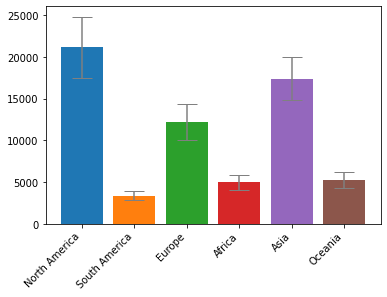

In [14]:
fig, ax = plt.subplots()
cons = ["North America", "South America", "Europe","Africa", "Asia", "Oceania"]

for i, con in enumerate(cons):
    cdf = df[df['id'].isin(doc_continents.loc[doc_continents['continent']==con,"doc_id"])]
    mid = cdf[cdf['0 - relevance - mean_prediction']>0.5].shape[0]
    ub = cdf[cdf['0 - relevance - upper_pred']>0.5].shape[0]
    lb = cdf[cdf['0 - relevance - lower_pred']>0.5].shape[0]
    
    ax.bar(i, mid)
    eay = np.array([[ub-mid,mid-lb]]).T
    
    ax.errorbar(i, mid, yerr=eay, color="grey", capsize=10)
    
ax.set_xticks(range(i+1))
ax.set_xticklabels(cons, rotation=45,ha="right")
    

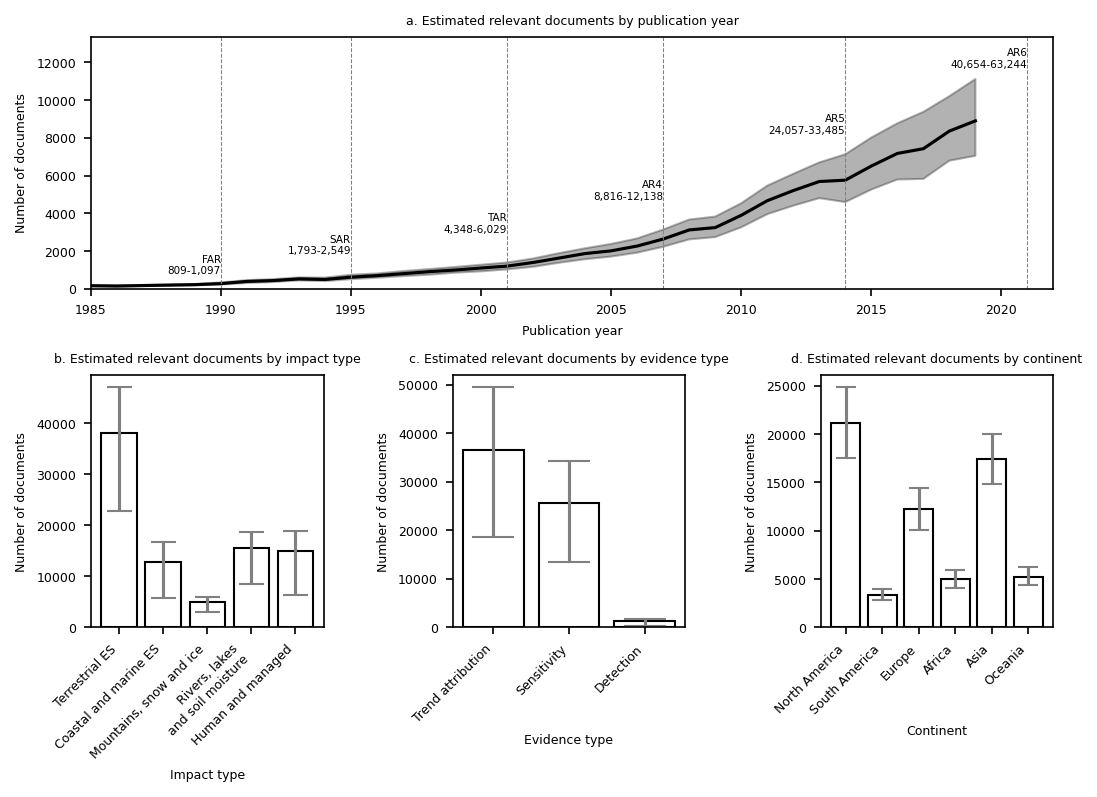

In [15]:
fig = plt.figure(figsize=(7.2,5.2), dpi=150, constrained_layout=True)
gs = fig.add_gridspec(6, 6)

#########################
## Time+uncertainty
ax = plt.subplot(gs[:3,0:])


lb = df[df['0 - relevance - lower_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"lb"})
mid = df[df['0 - relevance - mean_prediction']>0.5].groupby('PY')['id'].size().to_frame().reset_index()
ub = df[df['0 - relevance - upper_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"ub"})

mid = mid[mid['PY']<2020]

bounds = lb.merge(ub, how="outer")

bounds = bounds[bounds['PY']<2020]

ax.plot(mid['PY'], mid['id'], color="black")

ax.fill_between(
    bounds['PY'], bounds['lb'], bounds['ub'],
    color="black",
    alpha=0.3
)

ax.set_xlim([1985,2019])

ax.set_xlabel('Publication year', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)

ax.tick_params(axis='both', labelsize=6) 

report_dates = [1990, 1995, 2001, 2007, 2014, 2021]
report_labels = ["FAR", "SAR", "TAR", "AR4", "AR5", "AR6"]

ymax = ub['ub'].max()

ld = 0

offsets = [350, 1000, 1500, 1500, 1000, 500]

for i, (d, l) in enumerate(zip(report_dates, report_labels)):
    #idx = py_range.index(d)
    
    # bounds for this reporting period
    r_lb = lb[lb['PY'].isin(range(ld,d))]['lb'].sum()
    r_ub = ub[ub['PY'].isin(range(ld,d))]['ub'].sum()
    

    
    if l=="AR6":
        y = ub.ub.max()
        ty = y+offsets[i]
        ax.axvline(d, color="grey",lw=0.5, ls="--")
        ax.text(d, ty, f"{l}\n{r_lb:,}-{r_ub:,}", va="bottom", ha="right", fontsize=5)
    else:
        y = ub[ub['PY']==d].ub.values[0]
        ty = y+offsets[i]
        ax.axvline(d, color="grey",lw=0.5, ls="--")
        ax.text(d, ty, f"{l}\n{r_lb:,}-{r_ub:,}", va="bottom", ha="right", fontsize=5)

    ld=d

ax.set_xlim([1985,2022])
ax.set_ylim([0,ymax*1.2])
ax.set_title("a. Estimated relevant documents by publication year", fontsize=6)
    
    
####################
## 

#ax = plt.subplot(gs[:3,3:])




######################################
##

ax = plt.subplot(gs[3:,:2])

colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3']

xticks = []
for i, c in enumerate(pred_cats):
    mid = df[
        (df['0 - relevance - mean_prediction']>0.5) & 
        (df[c]>0.5)
    ].shape[0]
    ub = df[
        (df['0 - relevance - upper_pred']>0.5) & 
        (df[c.replace('mean_prediction','upper_pred')]>0.5)
    ].shape[0]
    lb = df[
        (df['0 - relevance - lower_pred']>0.5) & 
        (df[c.replace('mean_prediction','lower_pred')]>0.5)
    ].shape[0]
    
    #ax.bar(i, mid,color=colors[i])
    ax.bar(i, mid, color="None",edgecolor="black")
    
    eay = np.array([[ub-mid,mid-lb]]).T
    
    ax.errorbar(i, mid, yerr=eay, color="grey", capsize=6)
    
    xticks.append(c.split("-")[1].strip())
    
ax.set_xticks(range(i+1))
ax.tick_params(axis='both', labelsize=6) 

xticks = [
    "Terrestrial ES",
    "Coastal and marine ES",
    "Mountains, snow and ice",
    "Rivers, lakes\n and soil moisture",
    "Human and managed",    
]
ax.set_xticklabels(xticks, rotation=45,ha="right")
ax.set_title("b. Estimated relevant documents by impact type", fontsize=6)
ax.set_xlabel('Impact type', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)


######################################
##

ax = plt.subplot(gs[3:,2:4])


xticks = []
for i, c in enumerate(attrib_cats):
    mid = df[
        (df['0 - relevance - mean_prediction']>0.5) & 
        (df[c]>0.5)
    ].shape[0]
    ub = df[
        (df['0 - relevance - upper_pred']>0.5) & 
        (df[c.replace('mean_prediction','upper_pred')]>0.5)
    ].shape[0]
    lb = df[
        (df['0 - relevance - lower_pred']>0.5) & 
        (df[c.replace('mean_prediction','lower_pred')]>0.5)
    ].shape[0]
    
    #ax.bar(i, mid,color=colors[i])
    ax.bar(i, mid, color="None",edgecolor="black")
    
    eay = np.array([[ub-mid,mid-lb]]).T
    
    ax.errorbar(i, mid, yerr=eay, color="grey", capsize=10)
    
    
ax.set_xticks(range(i+1))
ax.tick_params(axis='both', labelsize=6) 

xticks = [
    "Trend attribution",
    "Sensitivity",
    "Detection"
]

ax.set_xticklabels(xticks, rotation=45,ha="right")
ax.set_title("c. Estimated relevant documents by evidence type", fontsize=6)

ax.set_xlabel('Evidence type', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)

######################################
##

ax = plt.subplot(gs[3:,4:6])

cons = ["North America", "South America", "Europe","Africa", "Asia", "Oceania"]

for i, con in enumerate(cons):
    cdf = df[df['id'].isin(doc_continents.loc[doc_continents['continent']==con,"doc_id"])]
    mid = cdf[cdf['0 - relevance - mean_prediction']>0.5].shape[0]
    ub = cdf[cdf['0 - relevance - upper_pred']>0.5].shape[0]
    lb = cdf[cdf['0 - relevance - lower_pred']>0.5].shape[0]
    
    #ax.bar(i, mid)
    ax.bar(i, mid, color="None",edgecolor="black")
    
    eay = np.array([[ub-mid,mid-lb]]).T
    
    ax.errorbar(i, mid, yerr=eay, color="grey", capsize=5)
    
ax.set_xticks(range(i+1))
ax.set_xticklabels(cons, rotation=45,ha="right")
ax.tick_params(axis='both', labelsize=6) 
ax.set_title("d. Estimated relevant documents by continent", fontsize=6)

ax.set_xlabel('Continent', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)

plt.savefig(f"../figures/figure_1.png", dpi=500, bbox_inches="tight")
plt.savefig(f"../figures/figure_1.svg")
plt.savefig(f"../figures/figure_1.pdf", bbox_inches="tight")

0.5641895835477563
0.20553134288591515
0.250102562939802
0.227362036939879
0.0343217634649867
0.013638085878272322
(-0.079135002979485, 1.0791350029794848)


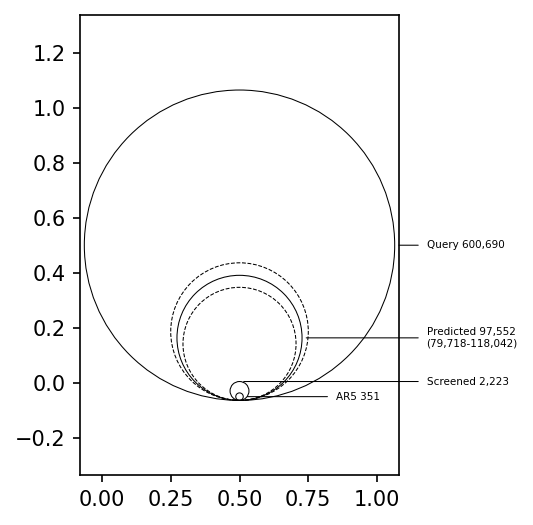

In [16]:
from matplotlib.patches import Circle
import math

predictions = pd.read_csv('../data/1_document_relevance.csv')
seen_df = pd.read_csv('../data/0_labelled_documents.csv')

fig, ax = plt.subplots(dpi=150, figsize=(3.6,3.6))

query_size = predictions.shape[0]
predicted_size = predictions[predictions['0 - relevance - mean_prediction']>0.5].shape[0]
upper_pred_size = predictions[predictions['0 - relevance - upper_pred']>0.5].shape[0]
lower_pred_size = predictions[predictions['0 - relevance - lower_pred']>0.5].shape[0]
screened_size = seen_df.shape[0]
ar5 = pd.read_csv('../literature_identification/IPCC_extraction.csv')
ar5_size = ar5.shape[0]

max_area = query_size

cols=["black","black","black","black"]
fill_cols = ['#7fc97f','#beaed4','#fdc086','#ffff99']

fill_cols = ["None"] * 4

fill_cols.reverse()
lw = .5

def draw_circle(label, size, max_size, ax, col, max_r=None, ytop=False, dotted=False, bounds="",label_offset=1.18):
    r = math.sqrt(size/max_size/math.pi)
    print(r)
    if dotted:
        ls = "--"
    else:
        ls = "-"
    if max_r is None:
        max_r = r
        y = 0.5
    else:
        y = 0.5-(max_r-r)
    circle = Circle(
        (0.5,y), r,
        color=col,
        ec="black",
        lw=lw,
        ls=ls,
        clip_on=False
    )
    ax.add_patch(circle)
    if ytop:
        ylab = y+r
        xlab = 0.5
    else:
        ylab = y
        xlab = 0.5+r
    if label:
        ax.annotate(
            f"{label} {size:,} {bounds}", (xlab,ylab), (label_offset,ylab), 
            arrowprops={"arrowstyle": "-",  "linewidth":0.5}, va="center",
            fontsize=5, annotation_clip=False
        )
    return r

#Query docs
max_r = draw_circle("Query", query_size, query_size, ax, fill_cols[0])
r = draw_circle(None, lower_pred_size, query_size, ax, fill_cols[1], max_r, dotted=True)
r = draw_circle(None, upper_pred_size, query_size, ax, fill_cols[1], max_r, dotted=True)
r = draw_circle("Predicted", predicted_size, query_size, ax, fill_cols[1], max_r, bounds=f"\n({lower_pred_size:,}-{upper_pred_size:,})")
r = draw_circle("Screened", screened_size, query_size, ax, fill_cols[2], max_r, True)
r = draw_circle("AR5", ar5_size, query_size, ax, fill_cols[3], max_r, False, label_offset=0.85)

ax.axis('equal')
ax.margins(0)
#ax.axis('off')

fig.tight_layout()

print(ax.get_xlim())

plt.show()

0.5641895835477563
0.20553134288591515
0.250102562939802
0.227362036939879
0.0343217634649867
0.013638085878272322


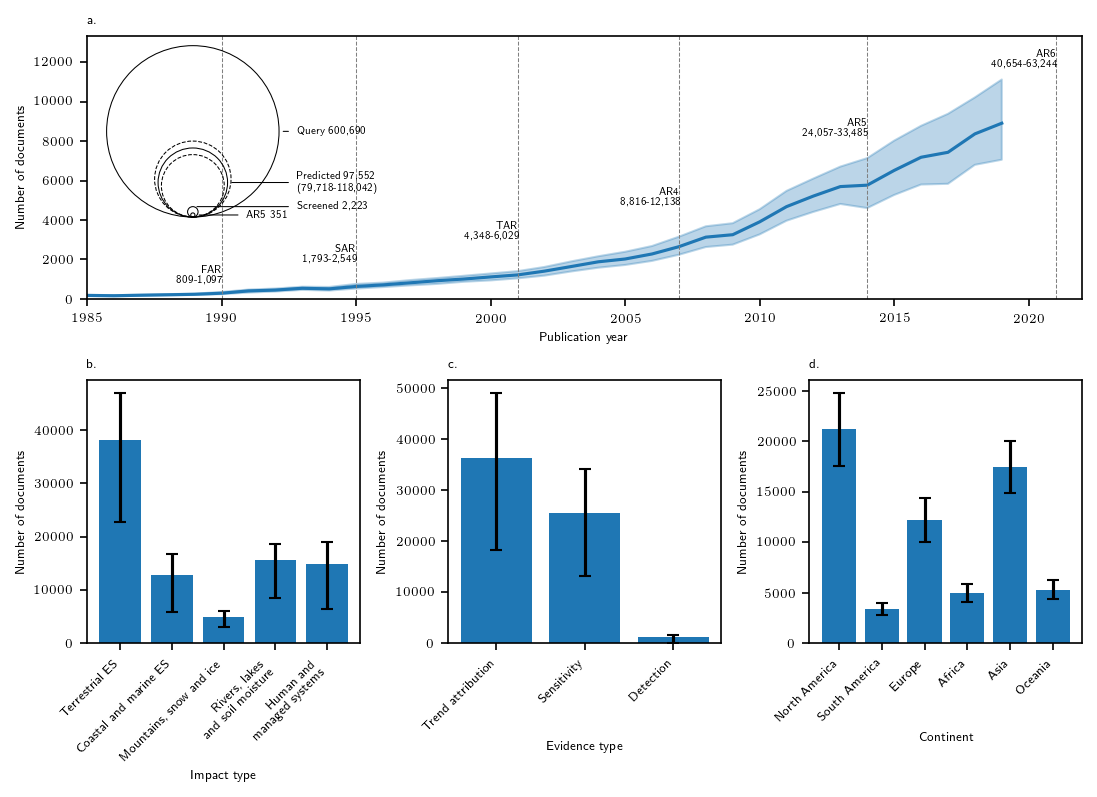

In [19]:
fig = plt.figure(figsize=(7.2,5.2), dpi=150, constrained_layout=True)
gs = fig.add_gridspec(6, 6)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

#########################
## Time+uncertainty
ax = plt.subplot(gs[:3,0:])


lb = df[df['0 - relevance - lower_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"lb"})
mid = df[df['0 - relevance - mean_prediction']>0.5].groupby('PY')['id'].size().to_frame().reset_index()
ub = df[df['0 - relevance - upper_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"ub"})

mid = mid[mid['PY']<2020]

bounds = lb.merge(ub, how="outer")

bounds = bounds[bounds['PY']<2020]

ax.plot(mid['PY'], mid['id'], color="C0")

ax.fill_between(
    bounds['PY'], bounds['lb'], bounds['ub'],
    color="C0",
    alpha=0.3
)

ax.set_xlim([1985,2019])

ax.set_xlabel('Publication year', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)

ax.tick_params(axis='both', labelsize=6) 

report_dates = [1990, 1995, 2001, 2007, 2014, 2021]
report_labels = ["FAR", "SAR", "TAR", "AR4", "AR5", "AR6"]

ymax = ub['ub'].max()

ld = 0

offsets = [350, 1000, 1500, 1500, 1000, 500]

for i, (d, l) in enumerate(zip(report_dates, report_labels)):
    #idx = py_range.index(d)
    
    # bounds for this reporting period
    r_lb = lb[lb['PY'].isin(range(ld,d))]['lb'].sum()
    r_ub = ub[ub['PY'].isin(range(ld,d))]['ub'].sum()
    

    
    if l=="AR6":
        y = ub.ub.max()
        ty = y+offsets[i]
        ax.axvline(d, color="grey",lw=0.5, ls="--")
        ax.text(d, ty, f"{l}\n{r_lb:,}-{r_ub:,}", va="bottom", ha="right", fontsize=5)
    else:
        y = ub[ub['PY']==d].ub.values[0]
        ty = y+offsets[i]
        ax.axvline(d, color="grey",lw=0.5, ls="--")
        ax.text(d, ty, f"{l}\n{r_lb:,}-{r_ub:,}", va="bottom", ha="right", fontsize=5)

    ld=d

ax.set_xlim([1985,2022])
ax.set_ylim([0,ymax*1.2])
ax.set_title("a.", fontsize=6, loc="left", fontweight="black")
    
    
####################
## 

# Inset axis 

ax = ax.inset_axes([0.00,0.4,0.32,0.6])

fill_cols = ["None"] * 4

#Query docs
max_r = draw_circle("Query", query_size, query_size, ax, fill_cols[0])
r = draw_circle(None, lower_pred_size, query_size, ax, fill_cols[1], max_r, dotted=True)
r = draw_circle(None, upper_pred_size, query_size, ax, fill_cols[1], max_r, dotted=True)
r = draw_circle("Predicted", predicted_size, query_size, ax, fill_cols[1], max_r, bounds=f"\n({lower_pred_size:,}-{upper_pred_size:,})")
r = draw_circle("Screened", screened_size, query_size, ax, fill_cols[2], max_r, True)
r = draw_circle("AR5", ar5_size, query_size, ax, fill_cols[3], max_r, False, label_offset=0.85)



ax.axis('equal')
ax.axis('off')
ax.set_xlim(xmin=0.4, xmax=1.3)
ax.set_ylim(ymin=0.1)


#ax = plt.subplot(gs[:3,3:])




######################################
##

ax = plt.subplot(gs[3:,:2])

colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3']

xticks = []
for i, c in enumerate(pred_cats):
    mid = df[
        (df['0 - relevance - mean_prediction']>0.5) & 
        (df[c]>0.5)
    ].shape[0]
    ub = df[
        (df['0 - relevance - upper_pred']>0.5) & 
        (df[c.replace('mean_prediction','upper_pred')]>0.5)
    ].shape[0]
    lb = df[
        (df['0 - relevance - lower_pred']>0.5) & 
        (df[c.replace('mean_prediction','lower_pred')]>0.5)
    ].shape[0]
    
    #ax.bar(i, mid,color=colors[i])
    ax.bar(i, mid, color="C0")
    
    eay = np.array([[ub-mid,mid-lb]]).T
    
    ax.errorbar(i, mid, yerr=eay, color="black", capsize=3,zorder=5)
    
    xticks.append(c.split("-")[1].strip())
    
ax.set_xticks(range(i+1))
ax.tick_params(axis='both', labelsize=6) 

xticks = [
    "Terrestrial ES",
    "Coastal and marine ES",
    "Mountains, snow and ice",
    "Rivers, lakes\n and soil moisture",
    "Human and\nmanaged systems",    
]
ax.set_xticklabels(xticks, rotation=45,ha="right")
ax.set_title("b.", fontsize=6, loc="left", fontweight="black")
ax.set_xlabel('Impact type', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)


######################################
##

ax = plt.subplot(gs[3:,2:4])


xticks = []
for i, c in enumerate(attrib_cats):
    mid = df[
        (df['0 - relevance - mean_prediction']>0.5) & 
        (df[c]>0.5)
    ].shape[0]
    ub = df[
        (df['0 - relevance - upper_pred']>0.5) & 
        (df[c.replace('mean_prediction','upper_pred')]>0.5)
    ].shape[0]
    lb = df[
        (df['0 - relevance - lower_pred']>0.5) & 
        (df[c.replace('mean_prediction','lower_pred')]>0.5)
    ].shape[0]
    
    #ax.bar(i, mid,color=colors[i])
    ax.bar(i, mid, color="C0")
    
    eay = np.array([[ub-mid,mid-lb]]).T
    
    ax.errorbar(i, mid, yerr=eay, color="black", capsize=3)
    
    
ax.set_xticks(range(i+1))
ax.tick_params(axis='both', labelsize=6) 

xticks = [
    "Trend attribution",
    "Sensitivity",
    "Detection"
]

ax.set_xticklabels(xticks, rotation=45,ha="right")
ax.set_title("c.", fontsize=6, loc="left", fontweight="black")

ax.set_xlabel('Evidence type', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)

######################################
##

ax = plt.subplot(gs[3:,4:6])

cons = ["North America", "South America", "Europe","Africa", "Asia", "Oceania"]

for i, con in enumerate(cons):
    cdf = df[df['id'].isin(doc_continents.loc[doc_continents['continent']==con,"doc_id"])]
    mid = cdf[cdf['0 - relevance - mean_prediction']>0.5].shape[0]
    ub = cdf[cdf['0 - relevance - upper_pred']>0.5].shape[0]
    lb = cdf[cdf['0 - relevance - lower_pred']>0.5].shape[0]
    
    #ax.bar(i, mid)
    ax.bar(i, mid, color="C0")
    
    eay = np.array([[ub-mid,mid-lb]]).T
    
    ax.errorbar(i, mid, yerr=eay, color="black", capsize=3)
    
ax.set_xticks(range(i+1))
ax.set_xticklabels(cons, rotation=45,ha="right")
ax.tick_params(axis='both', labelsize=6) 
ax.set_title("d.", fontsize=6, loc="left", fontweight="bold")

ax.set_xlabel('Continent', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)

plt.savefig(f"../figures/figure_1.png", dpi=500, bbox_inches="tight")
plt.savefig(f"../figures/figure_1.svg")
plt.savefig(f"../figures/figure_1.pdf", bbox_inches="tight", usetex=True)

In [18]:
seen_df = pd.read_csv('../data/0_labelled_documents.csv')
cat_df = pd.read_csv('../data/1_predicted_category_documents.csv')
predictions = pd.read_csv('../data/1_document_relevance.csv')
df = cat_df.merge(cat_df.merge(predictions), how="outer")

# Merge actual and predicted categories
pred_cats = [c for c  in df.columns if "12 - " in c and " - mean_prediction" in c]
for c in pred_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    cs = [c, c.replace('mean_prediction','lower_pred'), c.replace('mean_prediction','upper_pred')]
    df.loc[df[label]==1,cs] = 1
    print(df[c].sum())
print(pred_cats)

pred_cats = [
    "12 - Terrestrial ES - mean_prediction",
    "12 - Coastal and marine Ecosystems - mean_prediction",
    "12 - Mountains, snow and ice - mean_prediction",
    "12 - Rivers, lakes, and soil moisture - mean_prediction",
    "12 - Human and managed - mean_prediction",
    #"12 - Total"
]

# Merge actual and predicted specific categories

extra_cat_df = pd.read_csv('../data/1_predicted_category_documents_specific.csv')

specific_impact_cats = [x for x in extra_cat_df.columns if "18 -" in x and "mean" in x]

extra_cat_df = extra_cat_df[["id"]+[x for x in extra_cat_df.columns if "18 - " in x] ]

df = df.merge(extra_cat_df, how="outer")

print(df.shape)

import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('../literature_identification/jupyter-google-e4b72bf44320.json', scope)
gc = gspread.authorize(credentials)
spreadsheet_key = '1o18FIQTmGSWJ_m1ePAzrcVhFlfesESCb2bIEG7ibJAA'
wb = gc.open_by_key(spreadsheet_key)
ws = wb.worksheet("category_label_numbers")
table = ws.get_all_values()
category_map = pd.DataFrame(table[1:], columns=table[0])

impact_columns = [x for x in df.columns if re.match("^4 - ",x)]
for x in impact_columns:
    row = category_map.loc[category_map['Specific category']==x.split(' - ')[1]]
    if row.shape[0]==0:
        continue
    for i, aggscheme in enumerate(row[['Proposed Aggregation 1', 'Proposed Aggregation 2']].values[0]):
        if aggscheme not in ['-','']:
            nc = f'{17+i} - {aggscheme}'
            if nc not in df.columns:
                df[nc] = 0
            df.loc[df[x]==1,nc] = 1

specific_impacts = [
    '18 - Terrestrial Water Cycle - mean_prediction',
    '18 - Drought & Floods - mean_prediction',
    '18 - Cryosphere - mean_prediction',
    '18 - Coastal and marine Ecosystems - mean_prediction',
    '18 - Terrestrial ES - mean_prediction',
    #'18 - Carbon Cycle - mean_prediction',
    '18 - Wildfires - mean_prediction',
    '18 - Food/Agriculture - mean_prediction',
    '18 - Livelihoods and wellbeing - mean_prediction',
    '18 - Health - mean_prediction',
    '18 - Displacement and migration - mean_prediction',
    #'18 - Other anthropogenic - mean_prediction'
]

for c in specific_impacts:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    cs = [c, c.replace('mean_prediction','lower_pred'), c.replace('mean_prediction','upper_pred')]
    df.loc[df[label]==1,cs] = 1
    print(df[c].sum())

# Merge actual and predicted relevance
pcols = [
    '0 - relevance - mean_prediction',
    '0 - relevance - lower_pred',
    '0 - relevance - upper_pred'
]

df.loc[df['relevant']==1,pcols]=1

df.head()

16663.56853902418
16799.56853902418
20151.340275980354
20414.340275980354
6370.38864770765
6505.399679651162
18346.567023831227
18614.56702383123
42423.04180061863
42839.04180061863
['12 - Coastal and marine Ecosystems - mean_prediction', '12 - Human and managed - mean_prediction', '12 - Mountains, snow and ice - mean_prediction', '12 - Rivers, lakes, and soil moisture - mean_prediction', '12 - Terrestrial ES - mean_prediction']
(120265, 284)
13153.186978795382
13299.186978795382
6179.329707313106
6241.329707313106
5015.571211510866
5088.571211510866
9326.325412233688
9395.325412233688
36547.6434056815
36822.6434056815
1463.682673722669
1493.682673722669
4423.2415895870945
4476.2415895870945
6349.4681782291955
6397.5492830151
6091.917419718631
6216.917419718631
1817.8905208962026
1849.1316340895667


,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,random_sample,...,17 - Ecosystem productivity and carbon cycle (CMES),17 - Distribution and range shifts (TES),17 - Phenology (TES),"17 - Physiology, metabolism, mortality and growth (TES)",17 - Community composition and interaction (TES),17 - Ecosystem productivity and carbon cycle (TES),17 - Wildfires,17 - Livelihoods and wellbeing,17 - Health,17 - Displacement and migration
0,0,701728,The cryosphere of mountain regions is highly s...,Mapping the snow line altitude for large glaci...,NaN,NaN,NaN,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,213918,Global warming has been predicted to slow the ...,Can in situ floats and satellite altimeters de...,NaN,"['Geosciences, Multidisciplinary']",NaN,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,384698,Droughts and landfalling tropical cyclones (TC...,Spatiotemporal patterns of drought/tropical cy...,NaN,NaN,NaN,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,275009,High latitude ecosystems are believed to be se...,Changes in nitrogen content and isotopic compo...,NaN,['Environmental Sciences'],NaN,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,36030,Landscape-scale net ecosystem CO2 exchange (NE...,Interannual variability of net ecosystem CO2 e...,NaN,"['Environmental Sciences; Geosciences, Multidi...",NaN,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
fig, ax = plt.subplots()
#colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3']

xticks = []
for i, c in enumerate(specific_impacts):
    mid = df[
        (df['0 - relevance - mean_prediction']>0.5) & 
        (df[c]>0.5)
    ].shape[0]
    ub = df[
        (df['0 - relevance - upper_pred']>0.5) & 
        (df[c.replace('mean_prediction','upper_pred')]>0.5)
    ].shape[0]
    lb = df[
        (df['0 - relevance - lower_pred']>0.5) & 
        (df[c.replace('mean_prediction','lower_pred')]>0.5)
    ].shape[0]
    ax.bar(i, mid,color="None",edgecolor="black")
    
    #eay = np.array([[ub-mid,mid-lb]]).T
    eay = np.array([[mid-lb,ub-mid]]).T
    
    ax.errorbar(i, mid, yerr=eay, color="grey", capsize=10)
    
    xticks.append(c.split("-")[1].strip())
    
ax.set_xticks(range(i+1))
ax.set_xticklabels(xticks)

# xticks = [
#     "Terrestrial ES",
#     "Coastal and marine ES",
#     "Mountains, snow and ice",
#     "Rivers, lakes\n and soil moisture",
#     "Human and managed",    
# ]
# ax.set_xticklabels(xticks, rotation=45,ha="right")
    

In [ ]:
fig, ax = plt.subplots()
#colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3']

xticks = []
for i, c in enumerate(specific_impacts):
    mid = df[
        (df['0 - relevance - mean_prediction']>0.5) & 
        (df[c]>0.5)
    ].shape[0]
    ub = df[
        (df['0 - relevance - upper_pred']>0.5) & 
        (df[c.replace('mean_prediction','upper_pred')]>0.5)
    ].shape[0]
    lb = df[
        (df['0 - relevance - lower_pred']>0.5) & 
        (df[c.replace('mean_prediction','lower_pred')]>0.5)
    ].shape[0]
    ax.barh(i, mid, color="None",edgecolor="black")
    
    #eay = np.array([[ub-mid,mid-lb]]).T
    eay = np.array([[mid-lb,ub-mid]]).T
    
    ax.errorbar(mid, i, xerr=eay, color="grey", capsize=10)
    
    xticks.append(c.split("-")[1].strip())
    
ax.set_yticks(range(i+1))
ax.set_yticklabels(xticks)

# xticks = [
#     "Terrestrial ES",
#     "Coastal and marine ES",
#     "Mountains, snow and ice",
#     "Rivers, lakes\n and soil moisture",
#     "Human and managed",    
# ]
# ax.set_xticklabels(xticks, rotation=45,ha="right")
    

In [ ]:
fig = plt.figure(figsize=(7.2,6), dpi=150, constrained_layout=True)
gs = fig.add_gridspec(6, 6)

#########################
## Time+uncertainty
ax = plt.subplot(gs[:3,2:])


lb = df[df['0 - relevance - lower_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"lb"})
mid = df[df['0 - relevance - mean_prediction']>0.5].groupby('PY')['id'].size().to_frame().reset_index()
ub = df[df['0 - relevance - upper_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"ub"})

mid = mid[mid['PY']<2020]

bounds = lb.merge(ub, how="outer")

bounds = bounds[bounds['PY']<2020]

ax.plot(mid['PY'], mid['id'], color="black")

ax.fill_between(
    bounds['PY'], bounds['lb'], bounds['ub'],
    color="black",
    alpha=0.3
)

ax.set_xlim([1985,2019])

ax.set_xlabel('Publication year', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)

ax.tick_params(axis='both', labelsize=6) 

report_dates = [1990, 1995, 2001, 2007, 2014, 2021]
report_labels = ["FAR", "SAR", "TAR", "AR4", "AR5", "AR6"]

ymax = ub['ub'].max()

ld = 0

offsets = [350, 500, 500, 500, 1000, 500]

for i, (d, l) in enumerate(zip(report_dates, report_labels)):
    #idx = py_range.index(d)
    
    # bounds for this reporting period
    r_lb = lb[lb['PY'].isin(range(ld,d))]['lb'].sum()
    r_ub = ub[ub['PY'].isin(range(ld,d))]['ub'].sum()
    

    
    if l=="AR6":
        y = ub.ub.max()
        ty = y+offsets[i]
        ax.axvline(d, color="grey",lw=0.5, ls="--")
        ax.text(d, ty, f"{l}\n{r_lb:,}-{r_ub:,}", va="bottom", ha="right", fontsize=5)
    else:
        y = ub[ub['PY']==d].ub.values[0]
        ty = y+offsets[i]
        ax.axvline(d, color="grey",lw=0.5, ls="--")
        ax.text(d, ty, f"{l}\n{r_lb:,}-{r_ub:,}", va="bottom", ha="right", fontsize=5)

    ld=d

ax.set_xlim([1985,2022])
ax.set_ylim([0,ymax*1.2])
ax.set_title("b. ", fontsize=6, fontweight="bold", loc="left")    
    
####################
## 

# Inset axis 

ax = ax.inset_axes([0.17,0.45,0.28,0.55])

fill_cols = ["None"] * 4

#Query docs
max_r = draw_circle("Query", query_size, query_size, ax, fill_cols[0])
r = draw_circle(None, lower_pred_size, query_size, ax, fill_cols[1], max_r, dotted=True)
r = draw_circle(None, upper_pred_size, query_size, ax, fill_cols[1], max_r, dotted=True)
r = draw_circle("Predicted", predicted_size, query_size, ax, fill_cols[1], max_r, bounds=f"\n({lower_pred_size:,}-{upper_pred_size:,})")
r = draw_circle("Screened", screened_size, query_size, ax, fill_cols[2], max_r, True)
r = draw_circle("AR5", ar5_size, query_size, ax, fill_cols[3], max_r, False, label_offset=0.85)



ax.axis('equal')
ax.axis('off')
ax.set_xlim(xmin=0.4, xmax=1.3)
ax.set_ylim(ymin=0.1)


#ax = plt.subplot(gs[:3,3:])




######################################
##

ax = plt.subplot(gs[:,:2])
ax.set_title("a. ", fontsize=6, fontweight="bold", loc="left")  

xticks = []
for i, c in enumerate(specific_impacts):
    mid = df[
        (df['0 - relevance - mean_prediction']>0.5) & 
        (df[c]>0.5)
    ].shape[0]
    ub = df[
        (df['0 - relevance - upper_pred']>0.5) & 
        (df[c.replace('mean_prediction','upper_pred')]>0.5)
    ].shape[0]
    lb = df[
        (df['0 - relevance - lower_pred']>0.5) & 
        (df[c.replace('mean_prediction','lower_pred')]>0.5)
    ].shape[0]
    ax.barh(i, mid, color="None",edgecolor="black")
    
    #eay = np.array([[ub-mid,mid-lb]]).T
    eay = np.array([[mid-lb,ub-mid]]).T
    
    ax.errorbar(mid, i, xerr=eay, color="grey", capsize=10)
    
    xticks.append(c.split("-")[1].strip().replace("and","\n&").replace('Ecosystems','ES'))
    
ax.set_yticks(range(i+1))
ax.set_yticklabels(xticks)

# ax.set_xticks(range(i+1))
ax.tick_params(axis='both', labelsize=6) 

# ax.set_xticklabels(xticks, rotation=45,ha="right")
# ax.set_title("b. Estimated relevant documents by impact type", fontsize=6)
ax.set_ylabel('Impact type', fontsize=6)
ax.set_xlabel('Number of documents', fontsize=6)


######################################
##

ax = plt.subplot(gs[3:,2:4])


xticks = []
for i, c in enumerate(attrib_cats):
    mid = df[
        (df['0 - relevance - mean_prediction']>0.5) & 
        (df[c])>0.5
    ].shape[0]
    ub = df[
        (df['0 - relevance - upper_pred']>0.5) & 
        (df[c.replace('mean_prediction','upper_pred')])>0.5
    ].shape[0]
    lb = df[
        (df['0 - relevance - lower_pred']>0.5) & 
        (df[c.replace('mean_prediction','lower_pred')])>0.5
    ].shape[0]
    
    #ax.bar(i, mid,color=colors[i])
    ax.bar(i, mid, color="None",edgecolor="black")
    
    eay = np.array([[ub-mid,mid-lb]]).T
    
    ax.errorbar(i, mid, yerr=eay, color="grey", capsize=10)
    
    
ax.set_xticks(range(i+1))
ax.tick_params(axis='both', labelsize=6) 

xticks = [
    "Trend attribution",
    "Sensitivity",
    "Detection"
]

ax.set_xticklabels(xticks, rotation=45,ha="right")
ax.set_title("c. ", fontsize=6, fontweight="bold", loc="left")  

ax.set_xlabel('Evidence type', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)

######################################
##

ax = plt.subplot(gs[3:,4:6])

cons = ["North America", "South America", "Europe","Africa", "Asia", "Oceania"]

for i, con in enumerate(cons):
    cdf = df[df['id'].isin(doc_continents.loc[doc_continents['continent']==con,"doc_id"])]
    mid = cdf[cdf['0 - relevance - mean_prediction']>0.5].shape[0]
    ub = cdf[cdf['0 - relevance - upper_pred']>0.5].shape[0]
    lb = cdf[cdf['0 - relevance - lower_pred']>0.5].shape[0]
    
    #ax.bar(i, mid)
    ax.bar(i, mid, color="None",edgecolor="black")
    
    eay = np.array([[ub-mid,mid-lb]]).T
    
    ax.errorbar(i, mid, yerr=eay, color="grey", capsize=5)
    
ax.set_xticks(range(i+1))
ax.set_xticklabels(cons, rotation=45,ha="right")
ax.tick_params(axis='both', labelsize=6) 
ax.set_title("d. ", fontsize=6, fontweight="bold", loc="left")  

ax.set_xlabel('Continent', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)

# plt.savefig(f"../figures/figure_1.png", dpi=500, bbox_inches="tight")
# plt.savefig(f"../figures/figure_1.svg")
# plt.savefig(f"../figures/figure_1.pdf", bbox_inches="tight")

In [ ]:
fig = plt.figure(figsize=(7.2,6), dpi=150, constrained_layout=True)
gs = fig.add_gridspec(6, 6)

#########################
## Time+uncertainty
ax = plt.subplot(gs[:3,2:])


lb = df[df['0 - relevance - lower_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"lb"})
mid = df[df['0 - relevance - mean_prediction']>0.5].groupby('PY')['id'].size().to_frame().reset_index()
ub = df[df['0 - relevance - upper_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"ub"})

mid = mid[mid['PY']<2020]

bounds = lb.merge(ub, how="outer")

bounds = bounds[bounds['PY']<2020]

ax.plot(mid['PY'], mid['id'], color="black")

ax.fill_between(
    bounds['PY'], bounds['lb'], bounds['ub'],
    color="black",
    alpha=0.3
)

ax.set_xlim([1985,2019])

ax.set_xlabel('Publication year', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)

ax.tick_params(axis='both', labelsize=6) 

report_dates = [1990, 1995, 2001, 2007, 2014, 2021]
report_labels = ["FAR", "SAR", "TAR", "AR4", "AR5", "AR6"]

ymax = ub['ub'].max()

ld = 0

offsets = [350, 500, 500, 500, 1000, 500]

for i, (d, l) in enumerate(zip(report_dates, report_labels)):
    #idx = py_range.index(d)
    
    # bounds for this reporting period
    r_lb = lb[lb['PY'].isin(range(ld,d))]['lb'].sum()
    r_ub = ub[ub['PY'].isin(range(ld,d))]['ub'].sum()
    

    
    if l=="AR6":
        y = ub.ub.max()
        ty = y+offsets[i]
        ax.axvline(d, color="grey",lw=0.5, ls="--")
        ax.text(d, ty, f"{l}\n{r_lb:,}-{r_ub:,}", va="bottom", ha="right", fontsize=5)
    else:
        y = ub[ub['PY']==d].ub.values[0]
        ty = y+offsets[i]
        ax.axvline(d, color="grey",lw=0.5, ls="--")
        ax.text(d, ty, f"{l}\n{r_lb:,}-{r_ub:,}", va="bottom", ha="right", fontsize=5)

    ld=d

ax.set_xlim([1985,2022])
ax.set_ylim([0,ymax*1.2])
ax.set_title("b. ", fontsize=6, fontweight="bold", loc="left")    
    
####################
## 

# Inset axis 

ax = ax.inset_axes([0.17,0.45,0.28,0.55])

fill_cols = ["None"] * 4

#Query docs
max_r = draw_circle("Query", query_size, query_size, ax, fill_cols[0])
r = draw_circle(None, lower_pred_size, query_size, ax, fill_cols[1], max_r, dotted=True)
r = draw_circle(None, upper_pred_size, query_size, ax, fill_cols[1], max_r, dotted=True)
r = draw_circle("Predicted", predicted_size, query_size, ax, fill_cols[1], max_r, bounds=f"\n({lower_pred_size:,}-{upper_pred_size:,})")
r = draw_circle("Screened", screened_size, query_size, ax, fill_cols[2], max_r, True)
r = draw_circle("AR5", ar5_size, query_size, ax, fill_cols[3], max_r, False, label_offset=0.85)



ax.axis('equal')
ax.axis('off')
ax.set_xlim(xmin=0.4, xmax=1.3)
ax.set_ylim(ymin=0.1)


#ax = plt.subplot(gs[:3,3:])




######################################
##

ax = plt.subplot(gs[:,:2])
ax.set_title("a. ", fontsize=6, fontweight="bold", loc="left")  

xticks = []
for i, c in enumerate(specific_impacts):
    mid = df[
        (df['0 - relevance - mean_prediction']>0.5) & 
        (df[c]>0.5)
    ].shape[0]
    ub = df[
        (df['0 - relevance - upper_pred']>0.5) & 
        (df[c.replace('mean_prediction','upper_pred')]>0.5)
    ].shape[0]
    lb = df[
        (df['0 - relevance - lower_pred']>0.5) & 
        (df[c.replace('mean_prediction','lower_pred')]>0.5)
    ].shape[0]
    ax.barh(i, mid, color="None",edgecolor="black")
    
    #eay = np.array([[ub-mid,mid-lb]]).T
    eay = np.array([[mid-lb,ub-mid]]).T
    
    ax.errorbar(mid, i, xerr=eay, color="grey", capsize=10)
    
    xticks.append(c.split("-")[1].strip().replace("and","\n&").replace('Ecosystems','ES'))
    
ax.set_yticks(range(i+1))
ax.set_yticklabels(xticks)

# ax.set_xticks(range(i+1))
ax.tick_params(axis='both', labelsize=6) 

# ax.set_xticklabels(xticks, rotation=45,ha="right")
# ax.set_title("b. Estimated relevant documents by impact type", fontsize=6)
ax.set_ylabel('Impact type', fontsize=6)
ax.set_xlabel('Number of documents', fontsize=6)


######################################
##

ax = plt.subplot(gs[3:,2:4])


xticks = []
for i, c in enumerate(attrib_cats):
    mid = df[
        (df['0 - relevance - mean_prediction']>0.5) & 
        (df[c])>0.5
    ].shape[0]
    ub = df[
        (df['0 - relevance - upper_pred']>0.5) & 
        (df[c.replace('mean_prediction','upper_pred')])>0.5
    ].shape[0]
    lb = df[
        (df['0 - relevance - lower_pred']>0.5) & 
        (df[c.replace('mean_prediction','lower_pred')])>0.5
    ].shape[0]
    
    #ax.bar(i, mid,color=colors[i])
    ax.bar(i, mid, color="None",edgecolor="black")
    
    eay = np.array([[ub-mid,mid-lb]]).T
    
    ax.errorbar(i, mid, yerr=eay, color="grey", capsize=10)
    
    
ax.set_xticks(range(i+1))
ax.tick_params(axis='both', labelsize=6) 

xticks = [
    "Trend attribution",
    "Sensitivity",
    "Detection"
]

ax.set_xticklabels(xticks, rotation=45,ha="right")
ax.set_title("c. ", fontsize=6, fontweight="bold", loc="left")  

ax.set_xlabel('Evidence type', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)

######################################
##

ax = plt.subplot(gs[3:,4:6])

cons = ["North America", "South America", "Europe","Africa", "Asia", "Oceania"]

for i, con in enumerate(cons):
    cdf = df[df['id'].isin(doc_continents.loc[doc_continents['continent']==con,"doc_id"])]
    mid = cdf[cdf['0 - relevance - mean_prediction']>0.5].shape[0]
    ub = cdf[cdf['0 - relevance - upper_pred']>0.5].shape[0]
    lb = cdf[cdf['0 - relevance - lower_pred']>0.5].shape[0]
    
    #ax.bar(i, mid)
    ax.bar(i, mid, color="None",edgecolor="black")
    
    eay = np.array([[ub-mid,mid-lb]]).T
    
    ax.errorbar(i, mid, yerr=eay, color="grey", capsize=5)
    
ax.set_xticks(range(i+1))
ax.set_xticklabels(cons, rotation=45,ha="right")
ax.tick_params(axis='both', labelsize=6) 
ax.set_title("d. ", fontsize=6, fontweight="bold", loc="left")  

ax.set_xlabel('Continent', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)

# plt.savefig(f"../figures/figure_1.png", dpi=500, bbox_inches="tight")
# plt.savefig(f"../figures/figure_1.svg")
# plt.savefig(f"../figures/figure_1.pdf", bbox_inches="tight")